# PART III: Fourier Analysis

- Gabriel Wendell Celestino Rocha
- Alberto Bezerra de Palhares Júnior
- Joab Morais Varela
- Rafael Chaves Souto Araújo

---

## 0. Setup

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from matplotlib.collections import PolyCollection, LineCollection

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.fft import fft, fftfreq
from scipy.signal import periodogram, spectrogram

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic functions

In [2]:
%matplotlib inline

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20



def sm_plot(grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    plt.grid(grid, linestyle = ':', color = '0.50')
    # plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    plt.minorticks_on()
    plt.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True, right = True, length = 5, width = 1, labelsize = 15)
    plt.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8, width = 1, labelsize = 15)
    
    
    
def sm_plot_mod(ax, grid = True, font = cm_font, font_size = 15):
    # plt.style.use('dark_background')
    ax.grid(True, linestyle = ':', color = '0.50')
    plt.rcParams['font.family'] = 'monospace'
    plt.rcParams['font.size'] = font_size
    ax.minorticks_on()
    ax.tick_params(axis = 'both', which = 'minor', direction = "in",
                        top = True,right = True, length = 5,width = 1, labelsize = 15)
    ax.tick_params(axis = 'both', which = 'major', direction = "in",
                        top = True, right = True, length = 8,width = 1, labelsize = 15)

---

## 1. Reading the Data

Reading river station, river-dam station and weather station data:

- **River station:** Kluserbrücke 
- **Weather station:** Wuppertal-Buchenhofen 
- **River-damn station:** Wupper-Talsperre 

- `data_reduced.csv`: Dataframe with all data from 1990 to 2024
- `data_reduced_weekly.csv`: Dataframe with data reduced according to a weekly average
- `data_reduced_monthly.csv`: Dataframe with data reduced according to a monthly average

In [3]:
df = pd.read_csv('Reduced_Data/data_reduced.csv', sep = ',')
df_weekly = pd.read_csv('Reduced_Data/data_reduced_weekly.csv', sep = ',')
df_monthly = pd.read_csv('Reduced_Data/data_reduced_monthly.csv', sep = ',')

# -------------------------------------------------------------------------------------------------

print('River station: Kluserbrücke')
print('Weather station: Wuppertal-Buchenhofen')
print('River-damn station: Wupper-Talsperre')

print('')

print('1) All Data (1990 - 2024):', df.shape)
print('2) Weekly Average:', df_weekly.shape)
print('3) Monthly Average:', df_monthly.shape)

River station: Kluserbrücke
Weather station: Wuppertal-Buchenhofen
River-damn station: Wupper-Talsperre

1) All Data (1990 - 2024): (24789, 13)
2) Weekly Average: (14201, 13)
3) Monthly Average: (12828, 13)


## 2. Fast Fourier Transform (FFT) $\&$ Periodogram

In [4]:
n = len(df['WATER-LEVEL'])
water_level = df['WATER-LEVEL'].values
dates = pd.to_datetime(df['MESS_DATUM'])
T = (dates[1] - dates[0]).days

# FFT
yf = fft(water_level)
xf = fftfreq(n, T)

pos_mask = xf > 0
xf = xf[pos_mask]
yf = np.abs(yf[pos_mask])

# Find the dominat frequency
dom_freq = xf[np.argmax(yf)]
dom_period = 1 / dom_freq

# Periodogram
f_ps, Pxx_den = periodogram(water_level)

# Spectrogram
f_spec, t, Sxx = spectrogram(water_level, nperseg = 128)

print('Dominant Frequency =', dom_freq, 'Hz')
print('Dominant Period =', dom_period, 'd =', dom_period/365, 'y')

Dominant Frequency = 2.0170236798580014e-05 Hz
Dominant Period = 49578.00000000001 d = 135.8301369863014 y


- ### Plot

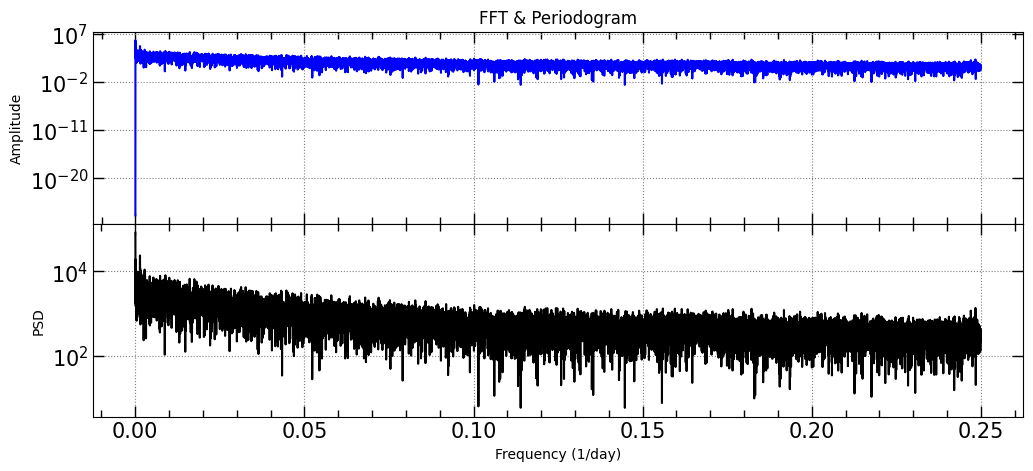

In [5]:
fig = plt.figure(figsize = (12,5))
fig.subplots_adjust(hspace = 0)
spec = gridspec.GridSpec(ncols = 1, nrows = 2, figure = fig)

ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[1, 0])

ax0.semilogy(f_ps, Pxx_den, color = 'b')
ax1.semilogy(xf, yf, color = 'k')

ax0.set_title('FFT & Periodogram')
ax0.set_xlabel('Frequency (1/day)')
ax0.set_ylabel('Amplitude')

ax1.set_xlabel('Frequency (1/day)')
ax1.set_ylabel('PSD')

sm_plot_mod(ax0)
sm_plot_mod(ax1)

## 3. Spectrogram $\&$ Echelle Diagram